# Chapter 2 - 불량 데이터들의 특징 찾기

<br></br>
## 1 Import Data_set
계층적 인덱스를 CSV로 저장/불러오면 컬럼이 1개만 지정되어 오류 (어찌보면 당연하다!!)

In [1]:
import os, glob
import pandas as pd
filelist = glob.glob('./Csv/*.*')

# 상단바 데이터 바꾸기
result = {}
df_tag = pd.read_excel(filelist[2], index_col=None)
for i, tag  in  enumerate(df_tag.변수영문명):
    result[tag] = df_tag.변수명[i]

# 데이터 테이블 적용하기
df_org = pd.read_csv(filelist[3], encoding='ms949')
df_org = df_org.drop('CUST_ID', axis=1)  # 불필요한 ID는 제거
table = df_org.rename(columns=result)

# 상단 tab 내용 추가하기
top = {}
for i, tag  in  enumerate(df_tag.변수명):
    top[tag] = df_tag.No[i]
cols = [top[col]  for col in table.columns]   
top  = [top[ids]  for ids in table.columns.tolist()]    
table.columns = [top , table.columns]  
table = table.sortlevel(0, axis=1)
# 불필요한 객체들은 삭제
del df_org, df_tag, result, tag, top, cols, filelist, i
table.head(2)

Hanhwa                                                                  ...  \
  가구추정소득 가족수 가족수/보험  막내나이 배우자소득 배우자직업  보험료/가구  보험료/보장 보험료/보장/가구    보험료/유효 ...   
0   7700   4      1  24.0     0    주부       0  190000    190000  20000000 ...   
1   8100   4      2  29.0     0    주부  300000       0    110000   7000000 ...   

     SKT                                     label         
  연체액/당월 연체액/연 월통화/분 월통화/빈도 정지일수 회선상태   회선수익    성별  연령 연체  
0      0     0   450    493    0    U  30000     1  50  0  
1      0     0    81     22    0    U  30000     1  50  0  

[2 rows x 68 columns]

In [2]:
%whos

Variable   Type         Data/Info
---------------------------------
glob       module       <module 'glob' from '/usr/lib/python3.6/glob.py'>
os         module       <module 'os' from '/home/<...>n36/lib/python3.6/os.py'>
pd         module       <module 'pandas' from '/h<...>ages/pandas/__init__.py'>
table      DataFrame           Hanhwa            <...>100233 rows x 68 columns]


In [3]:
print(table['label']['연체'].value_counts())
print('\n연체데이터 비율 : {} %'.format(round(table['label']['연체'].value_counts()[1]/
                                     table['label']['연체'].value_counts()[0] * 100, 3)))

0    95946
1     4287
Name: 연체, dtype: int64

연체데이터 비율 : 4.468 %


In [4]:
# 현재 5%에 불과한 연체데이터만 추출된다
# 앞으로 진행과정
# 1. 연체데이터를 딥러닝으로 분석하여 특징을 추출한다
# 2. 비연체 데이터를 세부분류를 통해 양호, 보통, 악화 등 몇가지로 특징을 찾은뒤, 이를 연체 데이터로 확장하여 모델을 완성한다

<br></br>
## 2 5%의 특징 찾기
연체자들의 특징을 우선 변별하기

In [5]:
%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
matplotlib.rc('font', family='NanumGothic')

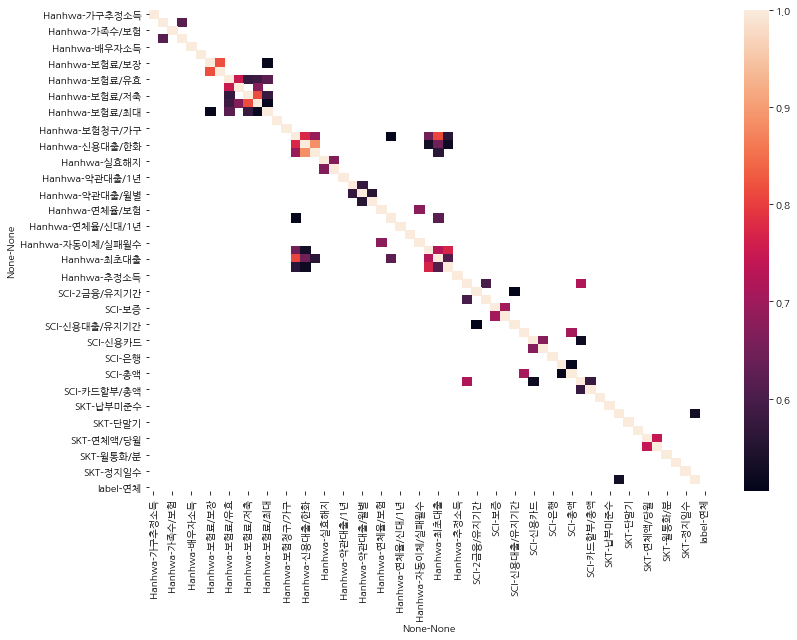

In [6]:
table_mal = table[table['label']['연체']==1]
table_mal_cor = table_mal.corr()
plt.subplots(1,1, figsize=(12,9))
table_mal_cor = table_mal_cor[abs(table_mal_cor) >= 0.5]
sns.heatmap(table_mal_cor)
plt.tight_layout(); plt.show()

In [7]:
def corr_list(df, under_limit = 0.5):
    # 상관성이 -+ 0.5 이상인 묶음 출력
    df_cor = df.corr()
    df_cor = df_cor.fillna(0)
    result = [ [colname, df_cor.index[i], float(str(col)[:5])]   
                        for colname in df_cor.columns
                        for i, col  in enumerate(df_cor[colname])
                        if abs(col) >= under_limit and col != 1]
    # 중복된 내용 제거한 순수한 결과값만 추출
    summary , check = [], []
    for col in result:
        if col[:2] not in check:
            check.append(col[:2])
            check.append(col[:2][::-1])
            summary.append(col)
        else:
            pass
    summary = pd.DataFrame(summary ,columns=['factor1', 'factor2','corr'])
    summary = summary.sort_values('corr',ascending=False)
    summary.reset_index(inplace=True); summary = summary.iloc[:,1:]
    return summary

In [8]:
frames = [corr_list(table), corr_list(table_mal)]
pd.concat(frames, axis = 1)

,factor1,factor2,corr,factor1,factor2,corr
0,"(Hanhwa, 신용대출/한화)","(Hanhwa, 신용상환/한화)",0.902,"(Hanhwa, 신용대출/한화)","(Hanhwa, 신용상환/한화)",0.885
1,"(Hanhwa, 보험료/보장)","(Hanhwa, 보험료/보장/가구)",0.820,"(Hanhwa, 보험료/보장)","(Hanhwa, 보험료/보장/가구)",0.816
2,"(Hanhwa, 보험료/저축)","(Hanhwa, 보험료/저축/가구)",0.811,"(Hanhwa, 보험료/저축)","(Hanhwa, 보험료/저축/가구)",0.814
3,"(Hanhwa, 신용대출)","(Hanhwa, 최초대출)",0.801,"(Hanhwa, 신용대출)","(Hanhwa, 최초대출)",0.810
4,"(Hanhwa, 신용대출)","(Hanhwa, 신용대출/한화)",0.796,"(Hanhwa, 신용대출)","(Hanhwa, 신용대출/한화)",0.773
5,"(SCI, 2금융)","(SCI, 카드할부)",0.792,"(Hanhwa, 최근등급)","(Hanhwa, 최초등급)",0.768
6,"(Hanhwa, 보험료/유효)","(Hanhwa, 보험료/유효/가구)",0.773,"(Hanhwa, 보험료/유효)","(Hanhwa, 보험료/유효/가구)",0.750
7,"(SCI, 보증)","(SCI, 보증/총액)",0.766,"(SKT, 연체액/당월)","(SKT, 연체액/연)",0.743
8,"(Hanhwa, 최근등급)","(Hanhwa, 최초등급)",0.763,"(Hanhwa, 최근등급)","(Hanhwa, 최초대출)",0.725
9,"(Hanhwa, 신용대출)","(Hanhwa, 신용상환/한화)",0.739,"(SCI, 2금융)","(SCI, 카드할부)",0.717


In [9]:
# print(table_mal['SKT']["납부요금"].value_counts()[:10])
# print(table_mal['SKT']["회선수익"].value_counts()[:10])
# print(table['SKT']["납부요금"].value_counts()[:10])
# print(table['SKT']["회선수익"].value_counts()[:10])

In [10]:
# 중간결론
# 단순 숫자들만의 비교만으로는 내용을 알기 힘들다
# 이를 구체적 시각화 작업이 필요하다

<br></br>
## 3 컬럼들의 특징 찾기
1. 전체분포
2. 기준을 정한뒤, 연체자/ 비연체자/ 전체의 평균을 비교

### 01 한화생명 데이터 분석['Hanhwa'] - 평균값
각 컬럼 데이터의 평균값 비교하기
1. table : 전체 데이터
2. table_mal : 연체자 데이터
3. table_normal : 비연체자 데이터

In [11]:
print(table['Hanhwa'].columns)
# print(table['Hanhwa']['가족수'].value_counts().keys())
# print(table['Hanhwa']['가족수'].value_counts().values)

Index(['가구추정소득', '가족수', '가족수/보험', '막내나이', '배우자소득', '배우자직업', '보험료/가구', '보험료/보장',
       '보험료/보장/가구', '보험료/유효', '보험료/유효/가구', '보험료/저축', '보험료/저축/가구', '보험료/최대',
       '보험완납/가구', '보험청구/가구', '신용대출', '신용대출/한화', '신용상환/한화', '실효해지', '실효해지/1년',
       '약관대출/1년', '약관대출/1년연체', '약관대출/월별', '약관대출/잔액', '연체율/보험', '연체율/보험/1년',
       '연체율/신대', '연체율/신대/1년', '연체율/신대/30', '자동이체/실패월수', '직업', '최근등급', '최초대출',
       '최초등급', '추정소득'],
      dtype='object')


In [12]:
# 다수 데이터 컬럼 추출
cols = table['Hanhwa'].columns
data = [table['Hanhwa'][col].value_counts().keys().tolist()    for col in cols]
data = pd.DataFrame(data).T
data.columns = [table['Hanhwa'][col].name    for col in cols]
data_keys = data[:15]

In [13]:
# 다수 데이터 값들 추출
data = [table['Hanhwa'][col].value_counts().values.tolist()    for col in cols]
data = pd.DataFrame(data).T
data.columns = [table['Hanhwa'][col].name    for col in cols]
data = round(data / data.sum() * 100, 2)
data_values = data[:15]

In [14]:
def value_count_table(data_keys, data_values, columns):
    df_keys = data_keys.iloc[:, columns ]
    df_vals = data_values.iloc[:, columns ]

    data_table = []
    for col in df_keys.columns:
        data = df_keys[col].tolist()
        data_val = df_vals[col].tolist()
        result = [ (data[i], data_val[i])  for i, datum in enumerate(data)]
        data_table.append(result)

    table_hanwha = pd.DataFrame(data_table).T        
    table_hanwha.columns = df_keys.columns
    return table_hanwha

In [15]:
# 가구의 개인정보
value_count_table(data_keys, data_values, [0,1,2,3,4,5, -5,-4,-3,-2,-1])

,가구추정소득,가족수,가족수/보험,막내나이,배우자소득,배우자직업,직업,최근등급,최초대출,최초등급,추정소득
0,"(0, 3.62)","(4, 23.49)","(1, 67.02)","(0.0, 50.53)","(0, 65.62)","(주부, 21.43)","(주부, 27.63)","(0, 94.74)","(0, 90.16)","(0, 96.18)","(0, 40.24)"
1,"(9900, 1.67)","(3, 23.39)","(2, 27.55)","(24.0, 10.86)","(4800, 1.66)","(사무직, 18.44)","(사무직, 16.62)","(6, 1.29)","(200103, 0.2)","(5, 0.91)","(4100, 2.33)"
2,"(4700, 1.62)","(2, 22.86)","(3, 4.64)","(19.0, 9.73)","(5000, 1.66)","(2차산업 종사자, 14.87)","(2차산업 종사자, 9.62)","(5, 1.12)","(200102, 0.2)","(4, 0.9)","(4000, 2.24)"
3,"(4800, 1.58)","(1, 21.9)","(4, 0.73)","(29.0, 7.97)","(4900, 1.61)","(자영업, 11.7)","(자영업, 9.51)","(4, 0.83)","(200208, 0.2)","(3, 0.72)","(4200, 2.21)"
4,"(10000, 1.57)","(5, 6.47)","(5, 0.06)","(14.0, 5.85)","(4700, 1.56)","(3차산업 종사자, 7.36)","(3차산업 종사자, 8.29)","(7, 0.65)","(200207, 0.2)","(2, 0.55)","(4300, 2.18)"
5,"(5200, 1.54)","(6, 1.6)","(None, nan)","(34.0, 5.64)","(5100, 1.55)","(운전직, 5.29)","(공무원, 5.1)","(8, 0.41)","(200109, 0.19)","(6, 0.5)","(4500, 2.18)"
6,"(4600, 1.53)","(7, 0.25)","(None, nan)","(39.0, 4.33)","(5200, 1.55)","(공무원, 4.4)","(전문직, 5.05)","(3, 0.27)","(200112, 0.18)","(1, 0.2)","(3800, 2.16)"
7,"(4900, 1.52)","(8, 0.04)","(None, nan)","(9.0, 2.88)","(4600, 1.48)","(전문직, 3.86)","(단순 사무직, 4.12)","(2, 0.27)","(200101, 0.18)","(7, 0.04)","(4400, 2.16)"
8,"(5100, 1.51)","(None, nan)","(None, nan)","(44.0, 1.23)","(4500, 1.43)","(1차산업 종사자, 2.59)","(학생, 3.84)","(10, 0.21)","(200210, 0.18)","(None, nan)","(3900, 2.16)"
9,"(5500, 1.49)","(None, nan)","(None, nan)","(4.0, 0.55)","(5300, 1.4)","(단순 사무직, 2.41)","(운전직, 2.13)","(9, 0.14)","(200108, 0.17)","(None, nan)","(4700, 2.14)"


In [16]:
value_count_table(data_keys, data_values, [7,8,9,10,11,12,13,14,15])

,보험료/보장,보험료/보장/가구,보험료/유효,보험료/유효/가구,보험료/저축,보험료/저축/가구,보험료/최대,보험완납/가구,보험청구/가구
0,"(0, 43.71)","(0, 38.3)","(4000000, 7.49)","(4000000, 5.71)","(0, 76.98)","(0, 72.04)","(0, 5.73)","(0, 39.3)","(0, 47.09)"
1,"(190000, 4.29)","(190000, 4.28)","(3000000, 6.82)","(3000000, 5.25)","(100000, 2.25)","(110000, 2.49)","(490000, 5.0)","(1, 32.0)","(1, 8.77)"
2,"(230000, 3.22)","(490000, 3.88)","(5000000, 6.41)","(5000000, 4.93)","(110000, 2.24)","(100000, 2.44)","(40000, 4.9)","(2, 13.92)","(2, 7.31)"
3,"(40000, 2.63)","(230000, 3.54)","(6000000, 5.2)","(6000000, 4.08)","(340000, 1.83)","(230000, 2.08)","(190000, 4.62)","(3, 6.77)","(3, 5.81)"
4,"(110000, 2.62)","(300000, 3.39)","(2000000, 5.18)","(2000000, 4.06)","(230000, 1.78)","(340000, 2.07)","(230000, 4.55)","(4, 3.57)","(4, 4.62)"
5,"(260000, 2.56)","(260000, 3.13)","(7000000, 4.74)","(7000000, 3.83)","(590000, 1.51)","(590000, 1.9)","(790000, 4.51)","(5, 1.96)","(5, 3.75)"
6,"(300000, 2.55)","(340000, 2.76)","(8000000, 4.0)","(8000000, 3.33)","(200000, 1.48)","(200000, 1.68)","(300000, 4.25)","(6, 1.01)","(6, 3.08)"
7,"(30000, 2.51)","(390000, 2.7)","(9000000, 3.46)","(9000000, 2.96)","(260000, 1.29)","(260000, 1.51)","(30000, 4.23)","(7, 0.57)","(7, 2.54)"
8,"(120000, 2.44)","(790000, 2.66)","(1000000, 3.25)","(10000000, 2.74)","(300000, 1.21)","(300000, 1.43)","(590000, 4.18)","(8, 0.32)","(8, 2.1)"
9,"(60000, 2.42)","(590000, 2.54)","(10000000, 3.11)","(1000000, 2.56)","(790000, 0.86)","(790000, 1.35)","(50000, 4.11)","(9, 0.2)","(9, 1.83)"


In [17]:
value_count_table(data_keys, data_values, [16,17,18,19,20])

,신용대출,신용대출/한화,신용상환/한화,실효해지,실효해지/1년
0,"(0, 90.16)","(0, 90.19)","(0, 91.59)","(0, 91.7)","(0, 98.33)"
1,"(1, 6.24)","(5000000, 2.04)","(5000000, 1.79)","(1, 6.24)","(1, 1.28)"
2,"(2, 2.15)","(4000000, 0.86)","(4000000, 0.86)","(2, 1.37)","(2, 0.27)"
3,"(3, 0.81)","(10000000, 0.84)","(3000000, 0.77)","(3, 0.42)","(3, 0.08)"
4,"(4, 0.34)","(3000000, 0.71)","(10000000, 0.64)","(4, 0.16)","(4, 0.03)"
5,"(5, 0.14)","(15000000, 0.49)","(2000000, 0.44)","(5, 0.05)","(6, 0.01)"
6,"(6, 0.07)","(20000000, 0.47)","(15000000, 0.36)","(6, 0.03)","(5, 0.01)"
7,"(7, 0.04)","(7000000, 0.43)","(7000000, 0.35)","(7, 0.03)","(None, nan)"
8,"(8, 0.02)","(8000000, 0.41)","(8000000, 0.31)","(None, nan)","(None, nan)"
9,"(9, 0.01)","(9000000, 0.37)","(20000000, 0.29)","(None, nan)","(None, nan)"


In [18]:
value_count_table(data_keys, data_values, [21,22,23,24,25])

,약관대출/1년,약관대출/1년연체,약관대출/월별,약관대출/잔액,연체율/보험
0,"(0, 89.21)","(0, 89.51)","(0, 77.85)","(0, 80.52)","(0, 27.17)"
1,"(1000000, 2.49)","(10, 3.65)","(100, 4.81)","(2000000, 3.14)","(1, 9.07)"
2,"(2000000, 2.0)","(20, 2.76)","(99, 1.37)","(3000000, 2.6)","(2, 8.95)"
3,"(3000000, 1.23)","(30, 1.69)","(98, 0.94)","(4000000, 2.0)","(3, 6.35)"
4,"(4000000, 0.81)","(40, 1.12)","(97, 0.77)","(1000000, 1.98)","(4, 5.31)"
5,"(5000000, 0.75)","(50, 0.96)","(96, 0.61)","(5000000, 1.56)","(5, 4.26)"
6,"(6000000, 0.4)","(60, 0.14)","(95, 0.56)","(6000000, 1.08)","(6, 3.63)"
7,"(10000000, 0.34)","(100, 0.09)","(94, 0.45)","(7000000, 0.8)","(7, 3.07)"
8,"(7000000, 0.3)","(70, 0.06)","(93, 0.42)","(8000000, 0.68)","(8, 2.8)"
9,"(8000000, 0.25)","(90, 0.02)","(92, 0.38)","(10000000, 0.66)","(9, 2.38)"


In [19]:
value_count_table(data_keys, data_values,[25,26,27,28,29,30])

,연체율/보험,연체율/보험/1년,연체율/신대,연체율/신대/1년,연체율/신대/30,자동이체/실패월수
0,"(0, 27.17)","(0, 73.1)","(0, 94.17)","(0, 99.4)","(0, 99.0)","(0, 64.57)"
1,"(1, 9.07)","(10미만, 12.43)","(4, 0.13)","(10, 0.24)","(1, 0.1)","(1, 8.82)"
2,"(2, 8.95)","(20미만, 7.18)","(2, 0.12)","(20, 0.1)","(2, 0.09)","(2, 4.94)"
3,"(3, 6.35)","(30미만, 3.01)","(3, 0.11)","(40, 0.07)","(3, 0.06)","(3, 3.34)"
4,"(4, 5.31)","(40미만, 1.75)","(8, 0.11)","(30, 0.05)","(4, 0.04)","(4, 2.49)"
5,"(5, 4.26)","(50미만, 0.85)","(34, 0.1)","(50, 0.03)","(8, 0.04)","(5, 2.02)"
6,"(6, 3.63)","(90미만, 0.7)","(32, 0.1)","(70, 0.03)","(14, 0.04)","(6, 1.65)"
7,"(7, 3.07)","(60미만, 0.68)","(31, 0.1)","(100, 0.03)","(16, 0.03)","(7, 1.31)"
8,"(8, 2.8)","(90이상, 0.28)","(10, 0.09)","(90, 0.02)","(5, 0.03)","(8, 1.16)"
9,"(9, 2.38)","(None, nan)","(5, 0.09)","(80, 0.02)","(36, 0.03)","(9, 0.97)"


In [20]:
# 비율 데이터 위 테이블과 이걸 합치면 가장 유효할 듯 하다!!

In [21]:
# # Normalization (정규화)
# # 수식 : (요소값 - 최소값) / (최대값 - 최소값)
# # 설명 : 데이터를 0과 1 사이의 값으로, 단위가 다른 데이터간 비교
# from sklearn.preprocessing import StandardScaler, Normalizer

# sn = Normalizer()
# sn.fit(X_train)
# X_train_std = sn.transform(X_train)
# X_train_std[:5]